**Upload `mnist_small_train.csv` and `mnist_small_test.csv` before running, in additon, skip *House cleaning* when running the first time**

# Installing PySpark

In [ ]:
import os

print("Current working directory:", os.getcwd())

Current working directory: /content


In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

In [ ]:
import findspark
findspark.init()

# House Cleaning


In [ ]:
spark.stop()
sc.stop()

In [ ]:
def remove(path):
    """ param <path> could either be relative or absolute. """
    if os.path.isfile(path) or os.path.islink(path):
        os.remove(path)  # remove the file
    elif os.path.isdir(path):
        shutil.rmtree(path)  # remove dir and all contains
    else:
        raise ValueError("file {} is not a file or dir.".format(path))

In [ ]:
#Unused code
#PLDT 03/05/2023 18:31

#path_to_delete = '/path/to/directory'
#remove(path_to_delete)

In [ ]:
#Should have a checker function when this is available.
import shutil
shutil.rmtree('/content/mnist_small_train_svd.csv')

#Task 1: Clustering (Done)



In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, array
from pyspark.ml.linalg import Vectors
import matplotlib.pyplot as plt

In [ ]:
#create a spark session
spark = SparkSession.builder.appName("Cluster").getOrCreate()
#read data into a df
df = spark.read.csv('/content/mnist_small_test.csv').limit(100)

df.show()

+---+---+---+---+---+---+---+---+---+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----

In [ ]:
#convert into a dense vector
df = df.rdd.map(lambda x: (x[0], Vectors.dense([float(it) for it in x[1:]])))\
           .toDF() \
           .select(col('_1').alias('label'), col('_2').alias('features'))
df.show()

## Show image

In [ ]:
from pyspark.ml.linalg import DenseVector
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, FloatType

# Define the number of rows and columns in the resulting matrix
num_rows, num_cols = 28, 28

# Define a UDF to reshape the dense vector into a matrix
def reshape_vector(vector):
    matrix = DenseVector(vector).toArray().reshape((num_rows, num_cols))
    return matrix.tolist()

reshape_udf = udf(reshape_vector, ArrayType(ArrayType(FloatType())))

# Apply the UDF to the features column and create a new column with the resulting matrices
matrix_df = df.withColumn('image_matrix', reshape_udf('features'))

# Show the first 10 rows of the resulting DataFrame
matrix_df.show(10)

+-----+--------------------+--------------------+
|label|            features|        image_matrix|
+-----+--------------------+--------------------+
|    1|[0.0,0.0,0.0,0.0,...|[[0.0, 0.0, 0.0, ...|
|    2|[0.0,0.0,0.0,0.0,...|[[0.0, 0.0, 0.0, ...|
|    2|[0.0,0.0,0.0,0.0,...|[[0.0, 0.0, 0.0, ...|
|    5|[0.0,0.0,0.0,0.0,...|[[0.0, 0.0, 0.0, ...|
|    8|[0.0,0.0,0.0,0.0,...|[[0.0, 0.0, 0.0, ...|
|    1|[0.0,0.0,0.0,0.0,...|[[0.0, 0.0, 0.0, ...|
|    3|[0.0,0.0,0.0,0.0,...|[[0.0, 0.0, 0.0, ...|
|    2|[0.0,0.0,0.0,0.0,...|[[0.0, 0.0, 0.0, ...|
|    9|[0.0,0.0,0.0,0.0,...|[[0.0, 0.0, 0.0, ...|
|    4|[0.0,0.0,0.0,0.0,...|[[0.0, 0.0, 0.0, ...|
+-----+--------------------+--------------------+
only showing top 10 rows



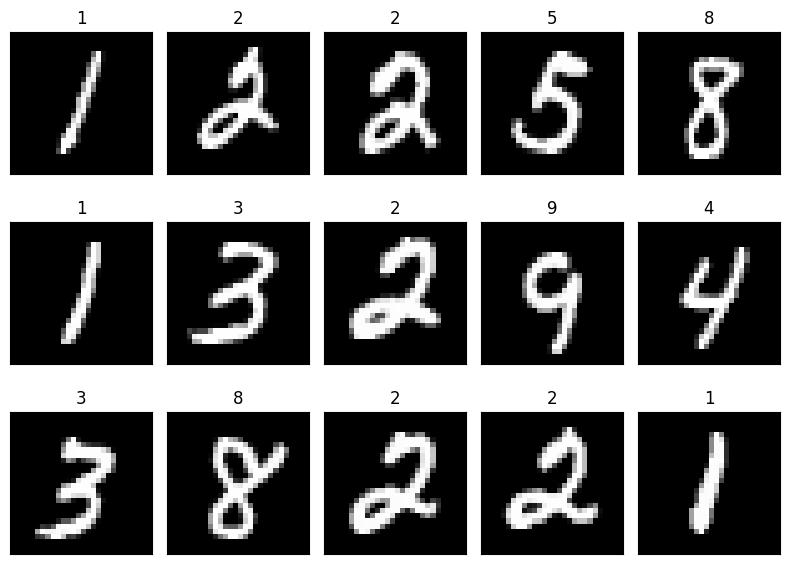

In [ ]:
import matplotlib.pyplot as plt

# Loop through the first 15 rows of the DataFrame and plot the images
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(8, 6))
for i, ax in enumerate(axes.flat):
    image = matrix_df.select('image_matrix').collect()[i][0]
    ax.imshow(image, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('{}'.format(matrix_df.select("label").collect()[i][0]))

plt.tight_layout()
plt.show()

## KMeans


### kmeans 15

In [ ]:
import shutil
shutil.rmtree('/content/kmeans15')

In [ ]:
from pyspark.ml.clustering import KMeans, KMeansModel
import math
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import udf
import os, tempfile
from pyspark.sql.functions import sum as spark_sum

kmeans15 = KMeans(k=15)
kmeans15.setMaxIter(50)
model15 = kmeans15.fit(df)
#save model
path = tempfile.mkdtemp()
model15.save('kmeans15')

In [ ]:
#load model
sameModel15 = KMeansModel.load('kmeans15')

df_pred = sameModel15.transform(df)
df_pred.show()

+-----+--------------------+----------+
|label|            features|prediction|
+-----+--------------------+----------+
|    1|[0.0,0.0,0.0,0.0,...|         6|
|    2|[0.0,0.0,0.0,0.0,...|        11|
|    2|[0.0,0.0,0.0,0.0,...|        11|
|    5|[0.0,0.0,0.0,0.0,...|         4|
|    8|[0.0,0.0,0.0,0.0,...|        10|
|    1|[0.0,0.0,0.0,0.0,...|         6|
|    3|[0.0,0.0,0.0,0.0,...|        13|
|    2|[0.0,0.0,0.0,0.0,...|        11|
|    9|[0.0,0.0,0.0,0.0,...|        10|
|    4|[0.0,0.0,0.0,0.0,...|         2|
|    3|[0.0,0.0,0.0,0.0,...|        10|
|    8|[0.0,0.0,0.0,0.0,...|         7|
|    2|[0.0,0.0,0.0,0.0,...|        11|
|    2|[0.0,0.0,0.0,0.0,...|        11|
|    1|[0.0,0.0,0.0,0.0,...|         6|
|    2|[0.0,0.0,0.0,0.0,...|        11|
|    8|[0.0,0.0,0.0,0.0,...|         7|
|    6|[0.0,0.0,0.0,0.0,...|         9|
|    5|[0.0,0.0,0.0,0.0,...|         4|
|    1|[0.0,0.0,0.0,0.0,...|         6|
+-----+--------------------+----------+
only showing top 20 rows



In [ ]:
# Get the cluster centers
centers = sameModel15.clusterCenters()

# Define a UDF to compute the Euclidean distance
dis = udf(lambda features, prediction: math.sqrt(Vectors.squared_distance(features,centers[prediction])), FloatType())

# Add a new column with the distance between each data point and its centroid
df_pred.withColumn('dist',dis(df_pred.features,df_pred.prediction)).show()
df_pred = df_pred.withColumn('dist', dis(df_pred.features, df_pred.prediction))

+-----+--------------------+----------+---------+
|label|            features|prediction|     dist|
+-----+--------------------+----------+---------+
|    1|[0.0,0.0,0.0,0.0,...|         6| 846.9165|
|    2|[0.0,0.0,0.0,0.0,...|        11|1371.2173|
|    2|[0.0,0.0,0.0,0.0,...|        11|1559.1083|
|    5|[0.0,0.0,0.0,0.0,...|         4|1076.0582|
|    8|[0.0,0.0,0.0,0.0,...|        10| 1243.218|
|    1|[0.0,0.0,0.0,0.0,...|         6| 621.1399|
|    3|[0.0,0.0,0.0,0.0,...|        13|1150.2789|
|    2|[0.0,0.0,0.0,0.0,...|        11|1047.7455|
|    9|[0.0,0.0,0.0,0.0,...|        10|1645.5021|
|    4|[0.0,0.0,0.0,0.0,...|         2|1278.5468|
|    3|[0.0,0.0,0.0,0.0,...|        10|1147.7268|
|    8|[0.0,0.0,0.0,0.0,...|         7|1423.2375|
|    2|[0.0,0.0,0.0,0.0,...|        11|1120.1559|
|    2|[0.0,0.0,0.0,0.0,...|        11| 1272.287|
|    1|[0.0,0.0,0.0,0.0,...|         6| 749.5989|
|    2|[0.0,0.0,0.0,0.0,...|        11|1450.4138|
|    8|[0.0,0.0,0.0,0.0,...|         7|1600.2588|


In [ ]:
# Compute the sum of distances for each cluster
cluster_sum = df_pred.groupBy('prediction').agg(spark_sum('dist').alias('sum_distance'))

# Compute the total sum of distances
total_sum_k15 = cluster_sum.agg(spark_sum('sum_distance')).collect()[0][0]

print('Total sum of distances: ', total_sum_k15)

Total sum of distances:  117234.32763671875


### kmeans 10

In [ ]:
from pyspark.ml.clustering import KMeans, KMeansModel
import math
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import udf
import os, tempfile
from pyspark.sql.functions import sum as spark_sum

kmeans10 = KMeans(k=10)
kmeans10.setMaxIter(50)
model10 = kmeans10.fit(df)
#save model
path = tempfile.mkdtemp()
model10.save('kmeans10')

In [ ]:
#load model
sameModel10 = KMeansModel.load('kmeans10')

df_pred = sameModel10.transform(df)
df_pred.show()

+-----+--------------------+----------+
|label|            features|prediction|
+-----+--------------------+----------+
|    1|[0.0,0.0,0.0,0.0,...|         6|
|    2|[0.0,0.0,0.0,0.0,...|         2|
|    2|[0.0,0.0,0.0,0.0,...|         9|
|    5|[0.0,0.0,0.0,0.0,...|         4|
|    8|[0.0,0.0,0.0,0.0,...|         0|
|    1|[0.0,0.0,0.0,0.0,...|         6|
|    3|[0.0,0.0,0.0,0.0,...|         3|
|    2|[0.0,0.0,0.0,0.0,...|         2|
|    9|[0.0,0.0,0.0,0.0,...|         1|
|    4|[0.0,0.0,0.0,0.0,...|         1|
|    3|[0.0,0.0,0.0,0.0,...|         0|
|    8|[0.0,0.0,0.0,0.0,...|         8|
|    2|[0.0,0.0,0.0,0.0,...|         2|
|    2|[0.0,0.0,0.0,0.0,...|         2|
|    1|[0.0,0.0,0.0,0.0,...|         6|
|    2|[0.0,0.0,0.0,0.0,...|         2|
|    8|[0.0,0.0,0.0,0.0,...|         0|
|    6|[0.0,0.0,0.0,0.0,...|         9|
|    5|[0.0,0.0,0.0,0.0,...|         4|
|    1|[0.0,0.0,0.0,0.0,...|         6|
+-----+--------------------+----------+
only showing top 20 rows



In [ ]:
# Get the cluster centers
centers = sameModel10.clusterCenters()

# Define a UDF to compute the Euclidean distance
dis = udf(lambda features, prediction: math.sqrt(Vectors.squared_distance(features,centers[prediction])), FloatType())

# Add a new column with the distance between each data point and its centroid
df_pred.withColumn('dist',dis(df_pred.features,df_pred.prediction)).show()
df_pred = df_pred.withColumn('dist', dis(df_pred.features, df_pred.prediction))

+-----+--------------------+----------+---------+
|label|            features|prediction|     dist|
+-----+--------------------+----------+---------+
|    1|[0.0,0.0,0.0,0.0,...|         6|840.03046|
|    2|[0.0,0.0,0.0,0.0,...|         2|1342.5496|
|    2|[0.0,0.0,0.0,0.0,...|         9|1751.1423|
|    5|[0.0,0.0,0.0,0.0,...|         4|1129.7466|
|    8|[0.0,0.0,0.0,0.0,...|         0|1098.7548|
|    1|[0.0,0.0,0.0,0.0,...|         6| 663.6109|
|    3|[0.0,0.0,0.0,0.0,...|         3|1106.2346|
|    2|[0.0,0.0,0.0,0.0,...|         2| 1031.659|
|    9|[0.0,0.0,0.0,0.0,...|         1|1699.3032|
|    4|[0.0,0.0,0.0,0.0,...|         1|1134.8832|
|    3|[0.0,0.0,0.0,0.0,...|         0|1271.1405|
|    8|[0.0,0.0,0.0,0.0,...|         8|1264.5791|
|    2|[0.0,0.0,0.0,0.0,...|         2|1128.6722|
|    2|[0.0,0.0,0.0,0.0,...|         2|1267.1387|
|    1|[0.0,0.0,0.0,0.0,...|         6| 780.9209|
|    2|[0.0,0.0,0.0,0.0,...|         2|1370.5979|
|    8|[0.0,0.0,0.0,0.0,...|         0|1376.5663|


In [ ]:
# Compute the sum of distances for each cluster
cluster_sum = df_pred.groupBy('prediction').agg(spark_sum('dist').alias('sum_distance'))

# Compute the total sum of distances
total_sum_k10 = cluster_sum.agg(spark_sum('sum_distance')).collect()[0][0]

print('Total sum of distances: ', total_sum_k10)

Total sum of distances:  131536.95147705078


### kmeans 5


In [ ]:
from pyspark.ml.clustering import KMeans, KMeansModel
import math
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import udf
import os, tempfile
from pyspark.sql.functions import sum as spark_sum

kmeans5 = KMeans(k=5)
kmeans5.setMaxIter(50)
model5 = kmeans5.fit(df)
#save model
path = tempfile.mkdtemp()
model5.save('kmeans5')

In [ ]:
#load model
sameModel5 = KMeansModel.load('kmeans5')

df_pred = sameModel5.transform(df)
df_pred.show()

+-----+--------------------+----------+
|label|            features|prediction|
+-----+--------------------+----------+
|    1|[0.0,0.0,0.0,0.0,...|         1|
|    2|[0.0,0.0,0.0,0.0,...|         2|
|    2|[0.0,0.0,0.0,0.0,...|         0|
|    5|[0.0,0.0,0.0,0.0,...|         4|
|    8|[0.0,0.0,0.0,0.0,...|         1|
|    1|[0.0,0.0,0.0,0.0,...|         1|
|    3|[0.0,0.0,0.0,0.0,...|         4|
|    2|[0.0,0.0,0.0,0.0,...|         2|
|    9|[0.0,0.0,0.0,0.0,...|         1|
|    4|[0.0,0.0,0.0,0.0,...|         1|
|    3|[0.0,0.0,0.0,0.0,...|         1|
|    8|[0.0,0.0,0.0,0.0,...|         1|
|    2|[0.0,0.0,0.0,0.0,...|         2|
|    2|[0.0,0.0,0.0,0.0,...|         2|
|    1|[0.0,0.0,0.0,0.0,...|         1|
|    2|[0.0,0.0,0.0,0.0,...|         2|
|    8|[0.0,0.0,0.0,0.0,...|         1|
|    6|[0.0,0.0,0.0,0.0,...|         0|
|    5|[0.0,0.0,0.0,0.0,...|         4|
|    1|[0.0,0.0,0.0,0.0,...|         1|
+-----+--------------------+----------+
only showing top 20 rows



In [ ]:
# Get the cluster centers
centers = sameModel5.clusterCenters()

# Define a UDF to compute the Euclidean distance
dis = udf(lambda features, prediction: math.sqrt(Vectors.squared_distance(features,centers[prediction])), FloatType())

# Add a new column with the distance between each data point and its centroid
df_pred.withColumn('dist',dis(df_pred.features,df_pred.prediction)).show()
df_pred = df_pred.withColumn('dist', dis(df_pred.features, df_pred.prediction))

+-----+--------------------+----------+---------+
|label|            features|prediction|     dist|
+-----+--------------------+----------+---------+
|    1|[0.0,0.0,0.0,0.0,...|         1|1532.8652|
|    2|[0.0,0.0,0.0,0.0,...|         2|1342.5496|
|    2|[0.0,0.0,0.0,0.0,...|         0|1724.5317|
|    5|[0.0,0.0,0.0,0.0,...|         4| 1233.214|
|    8|[0.0,0.0,0.0,0.0,...|         1|1672.7753|
|    1|[0.0,0.0,0.0,0.0,...|         1|1446.8624|
|    3|[0.0,0.0,0.0,0.0,...|         4|1280.5237|
|    2|[0.0,0.0,0.0,0.0,...|         2| 1031.659|
|    9|[0.0,0.0,0.0,0.0,...|         1|1719.1779|
|    4|[0.0,0.0,0.0,0.0,...|         1|1401.4215|
|    3|[0.0,0.0,0.0,0.0,...|         1| 1527.281|
|    8|[0.0,0.0,0.0,0.0,...|         1|1778.2439|
|    2|[0.0,0.0,0.0,0.0,...|         2|1128.6722|
|    2|[0.0,0.0,0.0,0.0,...|         2|1267.1387|
|    1|[0.0,0.0,0.0,0.0,...|         1|1489.5604|
|    2|[0.0,0.0,0.0,0.0,...|         2|1370.5979|
|    8|[0.0,0.0,0.0,0.0,...|         1| 1871.038|


In [ ]:
# Compute the sum of distances for each cluster
cluster_sum = df_pred.groupBy('prediction').agg(spark_sum('dist').alias('sum_distance'))

# Compute the total sum of distances
total_sum_k5 = cluster_sum.agg(spark_sum('sum_distance')).collect()[0][0]

print('Total sum of distances: ', total_sum_k5)

Total sum of distances:  152156.30310058594


###Result visualize

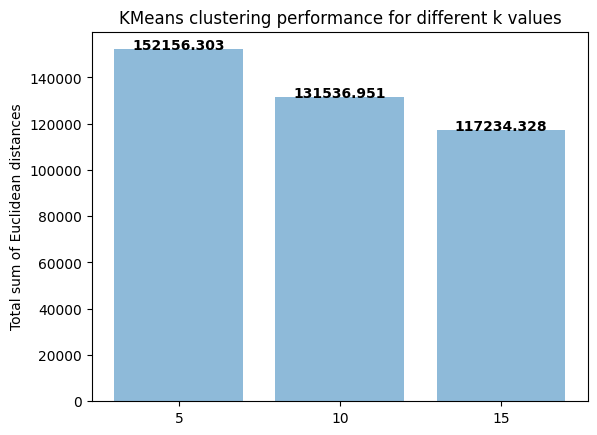

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# Define the k values for which we want to plot the results
k_values = [5, 10, 15]

# Define the total sums of squared distances for each k value
total_sums = [total_sum_k5, total_sum_k10, total_sum_k15]

# Plot the bar chart
fig, ax = plt.subplots()
ax.bar(np.arange(len(k_values)), total_sums, align='center', alpha=0.5)
ax.set_xticks(np.arange(len(k_values)))
ax.set_xticklabels(k_values)
ax.set_ylabel('Total sum of Euclidean distances')
ax.set_title('KMeans clustering performance for different k values')

# Display the exact numbers on each bar, rounded to 3 decimal places
for i, v in enumerate(total_sums):
    ax.text(i, v, "{:.3f}".format(v), color='black', fontweight='bold', ha='center')


plt.show()

# Task 2: Dimensionality Reduction (WORKING)

## Train

In [ ]:
from pyspark import SparkContext
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.linalg.distributed import RowMatrix
import numpy as np
import csv

In [ ]:
#following PySparkTutorials of Mr.An 
# Define the input and output file paths
input_path = "/content/mnist_small_train.csv"
output_path = "/content/mnist_small_train_svd.csv"

# Create a Spark context
sc = SparkContext("local", "SVD")

In [ ]:
# Load the input data from the CSV file and parse it into (label, feature) tuples
data = sc.textFile(input_path).map(lambda line: tuple(line.split(",", 1)))
# Extract only the feature vector from each tuple and convert it to a Vector
features = data.map(lambda x: Vectors.dense([float(i) for i in x[1].split(",")]))

In [ ]:
import pandas as pd

# Convert PipelinedRDD to pandas DataFrame to check
df = pd.DataFrame(data.collect())
df

,0,1
0,7,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,..."
1,2,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,..."
2,1,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,..."
3,0,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,..."
4,4,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,..."
...,...,...
6995,4,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,..."
6996,9,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,..."
6997,4,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,..."
6998,9,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,..."


In [ ]:
# Create a RowMatrix from the data
#mat = RowMatrix(data)
mat = RowMatrix(features)

# Compute the SVD of the matrix and get the U, S, and V matrices
svd = mat.computeSVD(196, computeU=True)
U = svd.U
s = svd.s #this need to be s not S for some reason
V = svd.V 

In [ ]:
# Multiply the U matrix with the singular values to get the reduced data
reduced_data = U.rows.map(lambda row: (row * s).toArray())

# Combine the label column with the reduced data to form (label, reduced_data) tuples
label_reduced_data = data.zip(reduced_data).map(lambda x: [float(x[0][0])] + x[1].tolist())

# Cache the RDD to avoid recomputing the SVD
label_reduced_data.cache()

PythonRDD[402] at RDD at PythonRDD.scala:53

In [ ]:
import pandas as pd

df = pd.DataFrame(label_reduced_data.collect())
df

,0,1,2,3,4,5,6,7,8,9,...,187,188,189,190,191,192,193,194,195,196
0,7.0,-1055.005321,248.244718,-598.132258,-0.717797,385.242274,572.808262,267.941212,663.100448,-90.226152,...,-23.543177,34.110743,-15.606965,-20.631938,8.597066,-8.789588,-4.845129,6.202333,-16.364380,13.706236
1,2.0,-1393.004031,-133.681947,1018.332204,81.291235,-277.464165,-392.264988,293.510614,155.637172,-313.423289,...,-7.612826,-40.288053,17.203241,42.341350,1.286444,-0.734451,-5.639195,5.603011,-8.283797,26.110131
2,1.0,-648.809758,549.281895,487.342624,288.599795,-79.728968,224.800368,188.461602,-302.132471,-132.090634,...,-16.457971,-29.706866,4.981351,-33.297987,-3.122522,-16.377859,-17.554461,-0.959679,-66.913474,4.950464
3,0.0,-2246.001287,-900.448759,-35.891545,188.103162,617.892539,-212.266997,548.128325,413.781602,70.004273,...,-14.135536,11.843813,-14.483327,-44.242483,23.311800,53.192239,17.504700,-10.746135,11.010311,-43.243824
4,4.0,-1106.075886,-451.020604,-814.494302,40.166073,-410.897242,8.945943,-268.763500,66.370419,-44.909915,...,-0.796445,-64.286787,57.094652,47.804945,3.099986,37.065951,-1.022231,2.797097,-41.107464,-60.042840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,4.0,-1361.527432,301.652469,-394.134595,607.092674,98.815843,-175.863989,-576.632165,-331.547458,-259.584171,...,19.670387,15.249457,-28.701830,19.278263,-48.651046,-58.915816,34.926794,-8.956225,-13.414495,-36.028884
6996,9.0,-1326.202228,712.617455,-506.453987,183.673109,316.255873,35.445115,7.813972,65.530325,344.880790,...,5.002001,-16.268772,-9.785164,-2.573121,1.002456,-1.246706,-2.913784,-7.846777,-35.670503,21.054412
6997,4.0,-1368.608628,804.714173,110.261574,187.989534,226.395297,43.804819,-280.780714,-395.730519,-91.576037,...,-14.909392,-4.812660,24.616509,-10.440432,-34.558074,-27.403941,34.063880,-19.137246,-26.908348,-19.584852
6998,9.0,-1661.566897,547.111909,-643.050432,385.335951,574.413094,22.622496,-210.931038,-41.818571,329.371861,...,-50.205658,-28.515700,-34.058518,39.692646,-2.798577,49.720054,18.607466,39.383073,-42.158037,15.302131


In [ ]:
# Save the reduced data to a CSV file
with open(output_path, "w") as f:
    writer = csv.writer(f)
    #for row in reduced_data.collect():
    for row in label_reduced_data.collect():
        writer.writerow(row)

## Test

In [ ]:
from pyspark import SparkContext
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.linalg.distributed import RowMatrix
import numpy as np
import csv

input_path = "/content/mnist_small_test.csv"
output_path = "/content/mnist_small_test_svd.csv"

# Load the input data from the CSV file and parse it into (label, feature) tuples
data = sc.textFile(input_path).map(lambda line: tuple(line.split(",", 1)))
# Extract only the feature vector from each tuple and convert it to a Vector
features = data.map(lambda x: Vectors.dense([float(i) for i in x[1].split(",")]))

In [ ]:
# Create a RowMatrix from the data
mat = RowMatrix(features)

# Compute the SVD of the matrix and get the U, S, and V matrices
svd = mat.computeSVD(196, computeU=True)
U = svd.U
s = svd.s #this need to be s not S
V = svd.V 

In [ ]:
# Multiply the U matrix with the singular values to get the reduced data
reduced_data_svd = U.rows.map(lambda row: (row * s).toArray())

# Combine the label column with the reduced data to form (label, reduced_data) tuples
label_reduced_data_svd = data.zip(reduced_data_svd).map(lambda x: [float(x[0][0])] + x[1].tolist())

# Cache the RDD to avoid recomputing the SVD
label_reduced_data_svd.cache()

PythonRDD[809] at RDD at PythonRDD.scala:53

In [ ]:
import pandas as pd

# Convert PipelinedRDD to pandas DataFrame
df = pd.DataFrame(label_reduced_data_svd.collect())
df

,0,1,2,3,4,5,6,7,8,9,...,187,188,189,190,191,192,193,194,195,196
0,1.0,-719.336823,-517.676027,-560.968574,-244.345334,211.322198,107.687917,379.441332,-268.722818,-32.381880,...,-15.353932,-10.231971,-4.289851,0.000823,1.495255,-2.650962,10.209352,-19.052111,1.850610,-11.285406
1,2.0,-1705.390328,-266.338804,-332.129837,-623.960334,-2.108565,28.689877,19.115734,331.757521,-15.818638,...,38.172199,-22.544177,22.772984,-19.780061,31.655997,17.252935,12.378097,-25.931362,-17.025510,16.399651
2,2.0,-2218.073320,47.072433,-21.154111,-184.794019,-117.336745,-264.275664,-170.836506,420.738637,663.817502,...,-29.273811,-8.160999,23.571415,22.216686,-63.074914,-31.367024,-24.786606,4.925951,-13.658045,12.597392
3,5.0,-1752.024057,169.540720,-629.262360,702.153920,148.800581,630.382267,-371.175394,314.623464,110.137865,...,-44.610519,13.542975,27.341046,-19.774472,-0.127146,-22.882538,42.999714,76.163333,-9.671932,-31.671808
4,8.0,-1591.575614,-676.191137,-423.445397,443.421250,-306.867662,100.827341,-172.311313,-299.983753,77.791082,...,23.477545,39.762567,6.578987,-6.428617,-8.307246,-25.940090,31.638274,-13.557286,-37.372791,28.895573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,2.0,-2209.420379,-390.750455,-614.307996,-8.128519,-650.550997,-780.804666,532.855222,537.387195,520.549227,...,57.865418,-25.378515,30.358551,-6.454907,-23.476244,2.859269,-56.106334,-2.409283,25.696756,-6.911808
2996,3.0,-1917.403906,241.552251,-699.503750,909.245345,-624.867327,303.093117,545.209046,566.463195,28.126048,...,-29.421510,-9.201433,-45.971200,-20.074695,-2.566481,-16.372978,-3.795789,-50.479452,-42.403631,-11.405306
2997,4.0,-1971.165299,-721.780966,690.089932,-212.919595,22.253756,5.356001,-356.491504,-48.767773,164.695212,...,46.752490,51.274721,-8.072673,57.798876,-17.248856,-54.190421,-30.914524,29.563438,-5.222798,-40.599537
2998,5.0,-1578.276037,-233.523411,-23.952617,-253.942674,575.375673,557.814322,61.171699,-23.487043,-201.137084,...,-51.511079,-19.152904,59.717472,-21.535225,8.325068,9.126746,49.947855,-11.676049,-14.068177,-19.396145


In [ ]:
# Save the reduced data to a CSV file
with open(output_path, "w") as f:
    writer = csv.writer(f)
    for row in label_reduced_data.collect():
        writer.writerow(row)

#Task3: Recommendation with Collaborative Filtering (Done)


In [ ]:
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row

spark = SQLContext(SparkContext('local', 'CF'))

In [ ]:
from pyspark.sql.functions import col,first
df = spark.read.option("header",True).csv('/content/ratings2k.csv')

df=df.withColumn('user',col("user").cast('integer'))
df=df.withColumn('item',col('item').cast('integer'))
df=df.withColumn('rating',col('rating').cast('float'))
training = df.orderBy(col('user'))
test = training.filter((col('user') > 70) & (col('item') > 400))

In [ ]:
training.show()

+-----+----+----+------+
|index|user|item|rating|
+-----+----+----+------+
|  390|   1| 352|   5.0|
|   32|   1| 167|   3.5|
| 1188|   1| 168|   5.0|
|  130|   1| 422|   3.5|
| 1544|   1| 163|   5.0|
|  674|   2| 288|   5.0|
| 1568|   2| 216|   1.0|
|  482|   2| 251|   5.0|
|  757|   2| 204|   4.5|
|   50|   2| 413|   3.5|
| 1108|   2| 310|   2.0|
|  139|   2| 183|   5.0|
| 1274|   2| 199|   4.5|
| 1485|   2| 271|   4.0|
| 1622|   2| 294|   4.5|
| 1097|   2|  82|   4.5|
| 1180|   2| 176|   5.0|
| 1213|   2|   0|   3.5|
| 1399|   2| 320|   2.0|
|  238|   2| 434|   4.0|
+-----+----+----+------+
only showing top 20 rows



In [ ]:
test.show()

+-----+----+----+------+
|index|user|item|rating|
+-----+----+----+------+
|    6|  72| 426|   4.0|
|   41|  72| 435|   4.0|
|  157|  72| 444|   3.0|
|  200|  72| 447|   4.0|
|  324|  72| 460|   3.0|
|  375|  72| 433|   4.0|
|  631|  72| 466|   1.0|
|  694|  72| 440|   3.0|
|  797|  72| 446|   2.0|
|  843|  72| 406|   2.0|
|  961|  72| 427|   4.0|
| 1035|  72| 437|   5.0|
| 1071|  72| 457|   4.0|
| 1176|  72| 434|   4.0|
| 1192|  72| 421|   4.0|
| 1228|  72| 432|   5.0|
| 1413|  72| 464|   5.0|
| 1501|  72| 413|   5.0|
| 1530|  72| 454|   5.0|
| 1585|  72| 412|   3.0|
+-----+----+----+------+
only showing top 20 rows



In [ ]:
als = ALS(maxIter=5, regParam=0.01, userCol="user", itemCol="item", ratingCol="rating",
          coldStartStrategy="drop")
model = als.fit(training)

In [ ]:
# Use the trained ALS model to predict the ratings of the last DataFrame
predictions = model.transform(test)

evaluator = RegressionEvaluator(metricName="mse", labelCol="rating", predictionCol="prediction")
mse = evaluator.evaluate(predictions)

# Print RMSE
print('Mean Squared Error = {:.4f}'.format(mse))

# Show example predictions
predictions.show()

Mean Squared Error = 0.0076
+-----+----+----+------+----------+
|index|user|item|rating|prediction|
+-----+----+----+------+----------+
| 2208|  72| 451|   4.0|  4.050446|
| 1898|  72| 436|   4.0|  4.005865|
|  843|  72| 406|   2.0|  2.192101|
| 1585|  72| 412|   3.0|  2.938842|
| 1208|  73| 412|   3.0| 3.0924602|
|  324|  72| 460|   3.0| 3.0378344|
| 1788|  72| 417|   2.0|  2.012427|
|  299|  73| 417|   3.0|  3.007647|
|  157|  72| 444|   3.0| 3.0443978|
|   41|  72| 435|   4.0| 4.0202446|
|  694|  72| 440|   3.0| 3.2422335|
| 1228|  72| 432|   5.0| 5.1234264|
| 2043|  72| 452|   4.0|  3.949532|
| 2132|  72| 425|   3.0| 3.0209284|
|  200|  72| 447|   4.0|  4.050446|
| 1897|  72| 462|   4.0| 3.9052527|
| 1035|  72| 437|   5.0| 4.7810526|
| 1701|  72| 456|   5.0|   4.81373|
|  797|  72| 446|   2.0| 1.9957384|
| 1587|  72| 453|   4.0|  4.050446|
+-----+----+----+------+----------+
only showing top 20 rows



# Task 4: Stock Price Regression (Done)


In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.regression import LinearRegression,LinearRegressionModel
from pyspark.sql.functions import col,lead,to_date,array
from pyspark.ml.functions import array_to_vector
from pyspark.sql.window import Window
from pyspark.ml.evaluation import RegressionEvaluator

#create a spark session
spark = SparkSession.builder.appName("local").getOrCreate()
#read data into a df
df = spark.read.option('header',True).csv('/content/stockHVN2022.csv')
df= df.withColumn('Ngay',to_date('Ngay','dd/MM/yyyy'))
df.show()

+----------+-----+
|      Ngay|  HVN|
+----------+-----+
|2022-11-18| 9.30|
|2022-11-17| 9.42|
|2022-11-16| 9.21|
|2022-11-15| 8.61|
|2022-11-14| 9.25|
|2022-11-11| 9.90|
|2022-11-10| 9.76|
|2022-11-09|10.40|
|2022-11-08|10.25|
|2022-11-07|10.10|
|2022-11-04|10.70|
|2022-11-03|10.85|
|2022-11-02|10.90|
|2022-11-01|10.90|
|2022-10-31|10.80|
|2022-10-28|10.75|
|2022-10-27|10.85|
|2022-10-26|10.55|
|2022-10-25|10.55|
|2022-10-24|10.55|
+----------+-----+
only showing top 20 rows



In [ ]:
w = Window.orderBy(df['Ngay'].desc())
df_train = df.withColumn('vector',array(lead('HVN',5).over(w).cast('double'),
                                        lead('HVN',4).over(w).cast('double'),
                                        lead('HVN',3).over(w).cast('double'),
                                        lead('HVN',2).over(w).cast('double'),
                                        lead('HVN',1).over(w).cast('double')))
#Remove data with null value in vector
df_train = df_train.filter('forall(vector, x -> x is not null)')

training = df_train.filter("Ngay < date'2022-7-1'")
test = df_train.filter("Ngay > date'2022-6-30'")


training = training.select(col('HVN').cast('double').alias('label'),array_to_vector('vector').alias("features"))
test = test.select(col('HVN').cast('double').alias('label'),array_to_vector('vector').alias("features"))

In [ ]:
#Show training DF
training.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
| 15.5|[15.3,15.25,16.3,...|
|16.05|[15.35,15.3,15.25...|
| 16.5|[14.95,15.35,15.3...|
| 16.3|[14.6,14.95,15.35...|
|15.25|[15.6,14.6,14.95,...|
| 15.3|[16.25,15.6,14.6,...|
|15.35|[16.15,16.25,15.6...|
|14.95|[17.1,16.15,16.25...|
| 14.6|[17.1,17.1,16.15,...|
| 15.6|[18.0,17.1,17.1,1...|
|16.25|[18.5,18.0,17.1,1...|
|16.15|[18.05,18.5,18.0,...|
| 17.1|[17.65,18.05,18.5...|
| 17.1|[17.9,17.65,18.05...|
| 18.0|[18.05,17.9,17.65...|
| 18.5|[18.0,18.05,17.9,...|
|18.05|[18.6,18.0,18.05,...|
|17.65|[18.65,18.6,18.0,...|
| 17.9|[19.15,18.65,18.6...|
|18.05|[18.6,19.15,18.65...|
+-----+--------------------+
only showing top 20 rows



In [ ]:
#Show testing DF
test.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  9.3|[9.9,9.25,8.61,9....|
| 9.42|[9.76,9.9,9.25,8....|
| 9.21|[10.4,9.76,9.9,9....|
| 8.61|[10.25,10.4,9.76,...|
| 9.25|[10.1,10.25,10.4,...|
|  9.9|[10.7,10.1,10.25,...|
| 9.76|[10.85,10.7,10.1,...|
| 10.4|[10.9,10.85,10.7,...|
|10.25|[10.9,10.9,10.85,...|
| 10.1|[10.8,10.9,10.9,1...|
| 10.7|[10.75,10.8,10.9,...|
|10.85|[10.85,10.75,10.8...|
| 10.9|[10.55,10.85,10.7...|
| 10.9|[10.55,10.55,10.8...|
| 10.8|[10.55,10.55,10.5...|
|10.75|[11.15,10.55,10.5...|
|10.85|[11.7,11.15,10.55...|
|10.55|[11.8,11.7,11.15,...|
|10.55|[11.65,11.8,11.7,...|
|10.55|[11.45,11.65,11.8...|
+-----+--------------------+
only showing top 20 rows



In [ ]:
lr= LinearRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)
lrModel = lr.fit(training)

print("Coefficients: %s" % str(lrModel.coefficients))
print("Intercept: %s" % str(lrModel.intercept))

Coefficients: [0.0,0.0707527673435071,0.1149039196217066,0.20472112509104612,0.533306001143217]
Intercept: 1.5863753375870966


In [ ]:
predictions = lrModel.transform(test)
predictions.select('label', 'prediction').show()

path = "linearRegress"
lrModel.write().overwrite().save(path)

loaded_model = LinearRegressionModel.load(path)

+-----+------------------+
|label|        prediction|
+-----+------------------+
|  9.3|10.139385276315071|
| 9.42| 10.02408614835154|
| 9.21| 9.899906228049895|
| 8.61|10.403486022443541|
| 9.25|10.784399559130252|
|  9.9|10.812909735983688|
| 9.76|11.148733480414538|
| 10.4| 11.11758467835395|
|10.25|11.181194679547525|
| 10.1|11.537631644978198|
| 10.7|11.620788324669883|
|10.85|11.632425594397697|
| 10.9|11.613283562641858|
| 10.9|11.539981468032103|
| 10.8|11.499317104597534|
|10.75|11.491231367184543|
|10.85|11.373691227247681|
|10.55|11.481547601059635|
|10.55| 11.67465270864055|
|10.55|12.108110404987201|
+-----+------------------+
only showing top 20 rows



In [ ]:
# Make prediction for training and test data set
train_predict = loaded_model.transform(training)
test_predict = loaded_model.transform(test)

# Compute MSE for training set
train_evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mse")
train_mse = train_evaluator.evaluate(train_predict)
print("Training set MSE: {:.3f}".format(train_mse))

# Compute MSE for test set
test_evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mse")
test_mse = test_evaluator.evaluate(test_predict)
print("Test set MSE: {:.3f}".format(test_mse))

Training set MSE: 0.424
Test set MSE: 0.568


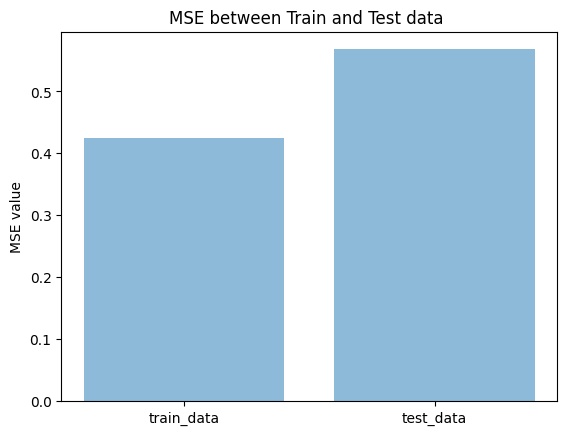

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the k values for which we want to plot the results
k_values = ["train_data","test_data"]

# Define the total sums of squared distances for each k value
total_mse = [train_mse,test_mse]

# Plot the bar chart
plt.bar(np.arange(len(k_values)), total_mse, align='center', alpha=0.5)
plt.xticks(np.arange(len(k_values)), k_values)
plt.ylabel('MSE value')
plt.title('MSE between Train and Test data ')
plt.show()


#Task 5: Multi-class Classification




In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col

# Create a Spark context
sc = SparkContext("local", "MCC_MLP")
#This is to ensure that it's looking at the right 
#SparkSession, don't ask me why.
#PLDT 04/05/2023 17:38
spark = SparkSession(sc) 

### Preprocessing

In [ ]:
#Can do backups, do not use
import os
import shutil

# specify the directory where the files are located
dir_path = "/content"

# specify the file names
file_names = ["mnist_small_train.csv", "mnist_small_test.csv", "mnist_small_train_svd.csv", "mnist_small_test_svd.csv"]

# loop over the files and add the header
for file_name in file_names:
    # create a backup of the original file
    try:
        shutil.copyfile(os.path.join(dir_path, file_name), os.path.join(dir_path, file_name + ".bak"))
    except Exception as e:
        print(f"Failed to create backup of {file_name}: {e}")
        continue

    # read the file into a list of lines
    with open(os.path.join(dir_path, file_name), "r") as f:
        lines = f.readlines()

    # add the header as the first line
    header_line = "label," + ",".join([f"pixel_{i}" for i in range(784)])
    lines.insert(0, header_line + "\n")

    # write the updated lines back to the file
    try:
        with open(os.path.join(dir_path, file_name), "w") as f:
            f.writelines(lines)
        print(f"Header added to {file_name}")
    except Exception as e:
        print(f"Failed to add header to {file_name}: {e}")
        # restore the backup file
        try:
            os.remove(os.path.join(dir_path, file_name))
            shutil.copyfile(os.path.join(dir_path, file_name + ".bak"), os.path.join(dir_path, file_name))
            print(f"Backup of {file_name} restored")
        except Exception as e:
            print(f"Failed to restore backup of {file_name}: {e}")

Header added to mnist_small_train.csv
Header added to mnist_small_test.csv
Header added to mnist_small_train_svd.csv
Header added to mnist_small_test_svd.csv


## Multi-layer Perceptron

### 784

In [ ]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [ ]:
# Load the input data from the CSV file
train_data = spark.read.format("csv").option("header", "true").load("mnist_small_train.csv")
test_data = spark.read.format("csv").option("header", "true").load("mnist_small_test.csv")


In [ ]:
from pyspark.sql.functions import col

for i in range(784):
    train_data = train_data.withColumn(f"pixel_{i}", col(f"pixel_{i}").cast("double"))
    test_data = test_data.withColumn(f"pixel_{i}", col(f"pixel_{i}").cast("double"))

In [ ]:
# Merge the pixel columns into a single feature column
assembler = VectorAssembler(inputCols=[f"pixel_{i}" for i in range(784)], outputCol="features")
train_data = assembler.transform(train_data.select("label", *[f"pixel_{i}" for i in range(784)]))
test_data = assembler.transform(test_data.select("label", *[f"pixel_{i}" for i in range(784)]))

# Split the data into training and test sets
train_set, test_set = train_data.randomSplit([0.8, 0.2], seed=42)

In [ ]:
# Convert the label column to numeric type
train_set = train_set.withColumn("label", train_set["label"].cast("double"))

# Define the MLP model
layers = [784, 64, 10]
mlp = MultilayerPerceptronClassifier(maxIter=100, layers=layers, blockSize=128, seed=42)

# Train the model on the training set
model = mlp.fit(train_set)

In [ ]:
# Convert the label column in the training and test sets to numeric type
train_set = train_set.withColumn("label", train_set["label"].cast("double"))
test_set = test_set.withColumn("label", test_set["label"].cast("double"))
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")

# Evaluate the model on the training set
train_accuracy_mlp = evaluator.evaluate(model.transform(train_set))
print("Training Accuracy = {:.2f}%".format(train_accuracy_mlp * 100))

# Evaluate the model on the test set
test_accuracy_mlp = evaluator.evaluate(model.transform(test_set))
print("Test Accuracy = {:.2f}%".format(test_accuracy_mlp * 100))


Training Accuracy = 91.49%
Test Accuracy = 88.03%


In [ ]:
from pyspark.ml.classification import MultilayerPerceptronClassificationModel

# Save the trained model
model.write().overwrite().save("mlp_model")

# Load the trained model
model = MultilayerPerceptronClassificationModel.load("mlp_model")


### SVD (196)

In [ ]:
# Load the input data from the CSV file
train_data = spark.read.format("csv").option("header", "true").load("mnist_small_train_svd.csv")
test_data = spark.read.format("csv").option("header", "true").load("mnist_small_test_svd.csv")

In [ ]:
from pyspark.sql.functions import col

for i in range(196):
    train_data = train_data.withColumn(f"pixel_{i}", col(f"pixel_{i}").cast("double"))
    test_data = test_data.withColumn(f"pixel_{i}", col(f"pixel_{i}").cast("double"))

In [ ]:
# Merge the pixel columns into a single feature column
#assembler = VectorAssembler(inputCols=[f"pixel_{i}" for i in range(196)], outputCol="features")
assembler = VectorAssembler(inputCols=[f"pixel_{i}" for i in range(196)], outputCol="features", handleInvalid="keep")
train_data = assembler.transform(train_data.select("label", *[f"pixel_{i}" for i in range(196)]))
test_data = assembler.transform(test_data.select("label", *[f"pixel_{i}" for i in range(196)]))

# Split the data into training and test sets
train_set, test_set = train_data.randomSplit([0.8, 0.2], seed=42)


In [ ]:
#Just in case
train_data.describe().show()

+-------+-----------------+------------------+-------------------+--------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+-------------------+-------------------+------------------+-------------------+-------------------+--------------------+-------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+-------------------+-------------------+-------------------+------------------+-------------------+-------------------+------------------+-------------------+------------------+-------------------+--------------------+------------------+-------------------+-------------------+-------------------+------------

In [ ]:
# Convert the label column to numeric type
train_set = train_set.withColumn("label", train_set["label"].cast("double"))

# Define the MLP model
layers = [196, 64, 10]
mlp = MultilayerPerceptronClassifier(maxIter=100, layers=layers, blockSize=64, seed=42)

# Train the model on the training set
model = mlp.fit(train_set)

In [ ]:
# Convert the label column in the training and test sets to numeric type
train_set = train_set.withColumn("label", train_set["label"].cast("double"))
test_set = test_set.withColumn("label", test_set["label"].cast("double"))
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")

# Evaluate the model on the training set
train_accuracy_mlp_svd = evaluator.evaluate(model.transform(train_set))
print("Training Accuracy = {:.2f}%".format(train_accuracy_mlp_svd * 100))

# Evaluate the model on the test set
test_accuracy_mlp_svd = evaluator.evaluate(model.transform(test_set))
print("Test Accuracy = {:.2f}%".format(test_accuracy_mlp_svd * 100))


Training Accuracy = 91.29%
Test Accuracy = 87.36%


In [ ]:
from pyspark.ml.classification import MultilayerPerceptronClassificationModel

# Save the trained model
model.write().overwrite().save("mlp_model_svd")

# Load the trained model
model = MultilayerPerceptronClassificationModel.load("mlp_model_svd")

In [ ]:
spark.stop()
sc.stop()

## Random Forest

In [ ]:
# Create a Spark context
sc = SparkContext("local", "MCC_RF")
#This is to ensure that it's looking at the right 
#SparkSession, don't ask me why.
#PLDT 04/05/2023 17:38
spark = SparkSession(sc) 

### 784

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassificationModel

In [ ]:
train_data = spark.read.format("csv").option("header", "true").load("mnist_small_train.csv")
test_data = spark.read.format("csv").option("header", "true").load("mnist_small_test.csv")

In [ ]:
from pyspark.sql.functions import col

for i in range(784):
    train_data = train_data.withColumn(f"pixel_{i}", col(f"pixel_{i}").cast("double"))
    test_data = test_data.withColumn(f"pixel_{i}", col(f"pixel_{i}").cast("double"))

In [ ]:
assembler = VectorAssembler(inputCols=[f"pixel_{i}" for i in range(784)], outputCol="features")
train_data = assembler.transform(train_data.select("label", *[f"pixel_{i}" for i in range(784)]))
test_data = assembler.transform(test_data.select("label", *[f"pixel_{i}" for i in range(784)]))
train_set, test_set = train_data.randomSplit([0.8, 0.2], seed=42)


In [ ]:
# Convert the label column to numeric type
train_set = train_set.withColumn("label", train_set["label"].cast("double"))

rf = RandomForestClassifier(numTrees=10, maxDepth=5, seed=42)
model = rf.fit(train_set)

In [ ]:
# Convert the label column in the training and test sets to numeric type
train_set = train_set.withColumn("label", train_set["label"].cast("double"))
test_set = test_set.withColumn("label", test_set["label"].cast("double"))

# Evaluate the model on the training set
train_accuracy_rf = evaluator.evaluate(model.transform(train_set))
print("Training Accuracy = {:.2f}%".format(train_accuracy_rf * 100))

# Evaluate the model on the test set
test_accuracy_rf = evaluator.evaluate(model.transform(test_set))
print("Test Accuracy = {:.2f}%".format(test_accuracy_rf * 100))

Training Accuracy = 81.16%


In [ ]:
model.write().overwrite().save("rf_model")
model = RandomForestClassificationModel.load("rf_model")

### 196

In [ ]:
# Load the input data from the CSV file
train_data = spark.read.format("csv").option("header", "true").load("mnist_small_train_svd.csv")
test_data = spark.read.format("csv").option("header", "true").load("mnist_small_test_svd.csv")

In [ ]:
for i in range(196):
    train_data = train_data.withColumn(f"pixel_{i}", col(f"pixel_{i}").cast("double"))
    test_data = test_data.withColumn(f"pixel_{i}", col(f"pixel_{i}").cast("double"))

In [ ]:
# Merge the pixel columns into a single feature column
#assembler = VectorAssembler(inputCols=[f"pixel_{i}" for i in range(196)], outputCol="features")
assembler = VectorAssembler(inputCols=[f"pixel_{i}" for i in range(196)], outputCol="features", handleInvalid="keep")
train_data = assembler.transform(train_data.select("label", *[f"pixel_{i}" for i in range(196)]))
test_data = assembler.transform(test_data.select("label", *[f"pixel_{i}" for i in range(196)]))

# Split the data into training and test sets
train_set, val_set = train_data.randomSplit([0.8, 0.2], seed=42)


In [ ]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassificationModel



# Convert the label column to numeric type
train_set = train_set.withColumn("label", train_set["label"].cast("double"))

# Define the Random Forest model
rf = RandomForestClassifier(numTrees=10, maxDepth=5, seed=42, labelCol="label", featuresCol="features")

# Train the model on the training set
model = rf.fit(train_set)


In [ ]:
# Convert the label column in the training and test sets to numeric type
train_set = train_set.withColumn("label", train_set["label"].cast("double"))
test_set = test_set.withColumn("label", test_set["label"].cast("double"))

# Evaluate the model on the training set
train_accuracy_rf_svd = evaluator.evaluate(model.transform(train_set))
print("Training Accuracy = {:.2f}%".format(train_accuracy_rf_svd * 100))

# Evaluate the model on the test set
test_accuracy_rf_svd = evaluator.evaluate(model.transform(test_set))
print("Test Accuracy = {:.2f}%".format(test_accuracy_rf_svd * 100))

Training Accuracy = 73.67%
Test Accuracy = 10.85%


In [ ]:
# Save the trained model
model.write().overwrite().save("rf_model_svd")

# Load the trained model
model = RandomForestClassificationModel.load("rf_model_svd")

In [ ]:
spark.stop()
sc.stop()

## Linear Support Vector Machine:

In [ ]:
# Create a Spark context
sc = SparkContext("local", "MCC_LSVM")
#This is to ensure that it's looking at the right 
#SparkSession, don't ask me why.
#PLDT 04/05/2023 17:38
spark = SparkSession(sc) 

### 784

In [ ]:
from pyspark.ml.classification import LinearSVC


In [ ]:
svm = LinearSVC(maxIter=100, regParam=0.1)

In [ ]:
train_data = spark.read.format("csv").option("header", "true").load("mnist_small_train.csv")
test_data = spark.read.format("csv").option("header", "true").load("mnist_small_test.csv")

In [ ]:
from pyspark.sql.functions import col

for i in range(784):
    train_data = train_data.withColumn(f"pixel_{i}", col(f"pixel_{i}").cast("double"))
    test_data = train_data.withColumn(f"pixel_{i}", col(f"pixel_{i}").cast("double"))

In [ ]:
# Merge the pixel columns into a single feature column
assembler = VectorAssembler(inputCols=[f"pixel_{i}" for i in range(784)], outputCol="features")
train_data = assembler.transform(train_data.select("label", *[f"pixel_{i}" for i in range(784)]))
test_data = assembler.transform(test_data.select("label", *[f"pixel_{i}" for i in range(784)]))

# Split the data into training and test sets
train_set, test_set = train_data.randomSplit([0.8, 0.2], seed=42)


In [ ]:
train_set = train_set.withColumn("label", train_set["label"].cast("double"))

In [ ]:
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import OneVsRest

# Define the Linear SVM model
svm = LinearSVC(maxIter=100, regParam=0.1)

# Wrap the model with OneVsRest
ovr = OneVsRest(classifier=svm)

# Train the OvR model on the training set
ovr_model = ovr.fit(train_set)

In [ ]:
# Convert the label column in the training and test sets to numeric type
train_set = train_set.withColumn("label", train_set["label"].cast("double"))
test_set = test_set.withColumn("label", test_set["label"].cast("double"))

# Evaluate the model on the training set
train_accuracy_lsvm = evaluator.evaluate(model.transform(train_set))
print("Training Accuracy = {:.2f}%".format(train_accuracy_lsvm * 100))

# Evaluate the model on the test set
test_accuracy_lsvm = evaluator.evaluate(model.transform(test_set))
print("Test Accuracy = {:.2f}%".format(test_accuracy_lsvm * 100))

Training Accuracy = 11.48%
Test Accuracy = 10.85%


In [ ]:
from pyspark.ml.classification import OneVsRestModel

# Save the trained model
ovr_model.write().overwrite().save("svm_model")

# Load the trained model
ovr_model = OneVsRestModel.load("svm_model")

### 196

In [ ]:
# Load the input data from the CSV file
train_data = spark.read.format("csv").option("header", "true").load("mnist_small_train_svd.csv")
test_data = spark.read.format("csv").option("header", "true").load("mnist_small_test_svd.csv")

In [ ]:
for i in range(196):
    train_data = train_data.withColumn(f"pixel_{i}", col(f"pixel_{i}").cast("double"))
    test_data = test_data.withColumn(f"pixel_{i}", col(f"pixel_{i}").cast("double"))

In [ ]:
# Merge the pixel columns into a single feature column
#assembler = VectorAssembler(inputCols=[f"pixel_{i}" for i in range(196)], outputCol="features")
assembler = VectorAssembler(inputCols=[f"pixel_{i}" for i in range(196)], outputCol="features", handleInvalid="keep")
train_data = assembler.transform(train_data.select("label", *[f"pixel_{i}" for i in range(196)]))
test_data = assembler.transform(test_data.select("label", *[f"pixel_{i}" for i in range(196)]))

# Split the data into training and test sets
train_set, test_set = train_data.randomSplit([0.8, 0.2], seed=42)


In [ ]:
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import OneVsRest

# Convert the label column to numeric type
train_set = train_set.withColumn("label", train_set["label"].cast("double"))

# Define the Linear SVM model
svm = LinearSVC(maxIter=100, regParam=0.1)

# Wrap the model with OneVsRest
ovr = OneVsRest(classifier=svm)

# Train the OvR model on the training set
ovr_model = ovr.fit(train_set)

In [ ]:
# Convert the label column in the training and test sets to numeric type
train_set = train_set.withColumn("label", train_set["label"].cast("double"))
test_set = test_set.withColumn("label", test_set["label"].cast("double"))

# Evaluate the model on the training set
train_accuracy_lsvm_svd = evaluator.evaluate(model.transform(train_set))
print("Training Accuracy = {:.2f}%".format(train_accuracy_lsvm_svd * 100))

# Evaluate the model on the test set
test_accuracy_lsvm_svd = evaluator.evaluate(model.transform(test_set))
print("Test Accuracy = {:.2f}%".format(test_accuracy_lsvm_svd * 100))

Training Accuracy = 73.67%
Test Accuracy = 66.42%


In [ ]:
from pyspark.ml.classification import OneVsRestModel

# Save the trained model
ovr_model.write().overwrite().save("svm_model_svd")

# Load the trained model
ovr_model = OneVsRestModel.load("svm_model_svd")

In [ ]:
spark.stop()
sc.stop()

## Evaluation

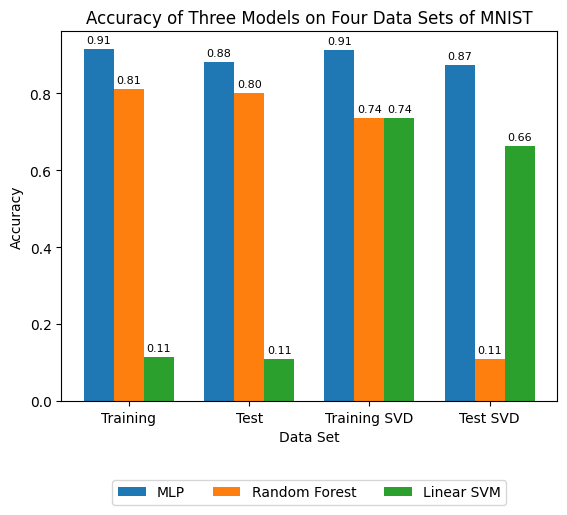

In [ ]:
import matplotlib.pyplot as plt

# Define the data for the bar chart
mlp_accuracies = [train_accuracy_mlp, test_accuracy_mlp, train_accuracy_mlp_svd, test_accuracy_mlp_svd]
rf_accuracies = [train_accuracy_rf, test_accuracy_rf, train_accuracy_rf_svd, test_accuracy_rf_svd]
svm_accuracies = [train_accuracy_lsvm, test_accuracy_lsvm, train_accuracy_lsvm_svd, test_accuracy_lsvm_svd]

# Define the labels for the x-axis and y-axis
x_labels = ["Training", "Test", "Training SVD", "Test SVD"]
y_label = "Accuracy"

# Define the width of each bar
bar_width = 0.25

# Define the positions of the bars on the x-axis
mlp_positions = [1, 2, 3, 4]
rf_positions = [x + bar_width for x in mlp_positions]
svm_positions = [x + bar_width for x in rf_positions]

# Create the figure and axis objects
fig, ax = plt.subplots()

# Plot the bars for each model
ax.bar(mlp_positions, mlp_accuracies, width=bar_width, label="MLP")
ax.bar(rf_positions, rf_accuracies, width=bar_width, label="Random Forest")
ax.bar(svm_positions, svm_accuracies, width=bar_width, label="Linear SVM")

# Add accuracy values to the chart
for i, model_accuracies in enumerate([mlp_accuracies, rf_accuracies, svm_accuracies]):
    for j, accuracy in enumerate(model_accuracies):
        x = [mlp_positions, rf_positions, svm_positions][i][j]
        ax.text(x, accuracy + 0.01, f"{accuracy:.2f}", ha='center', va='bottom', fontsize=8)

# Add labels and title to the chart
ax.set_xlabel("Data Set")
ax.set_ylabel(y_label)
ax.set_title("Accuracy of Three Models on Four Data Sets of MNIST")
ax.set_xticks([x + bar_width for x in mlp_positions])
ax.set_xticklabels(x_labels)

# Move legend to bottom center
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=3)

# Show the chart
plt.show()
